In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Subir un nivel desde el directorio actual del notebook
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from train_pinn import FireSpread_PINN

Using device: cuda


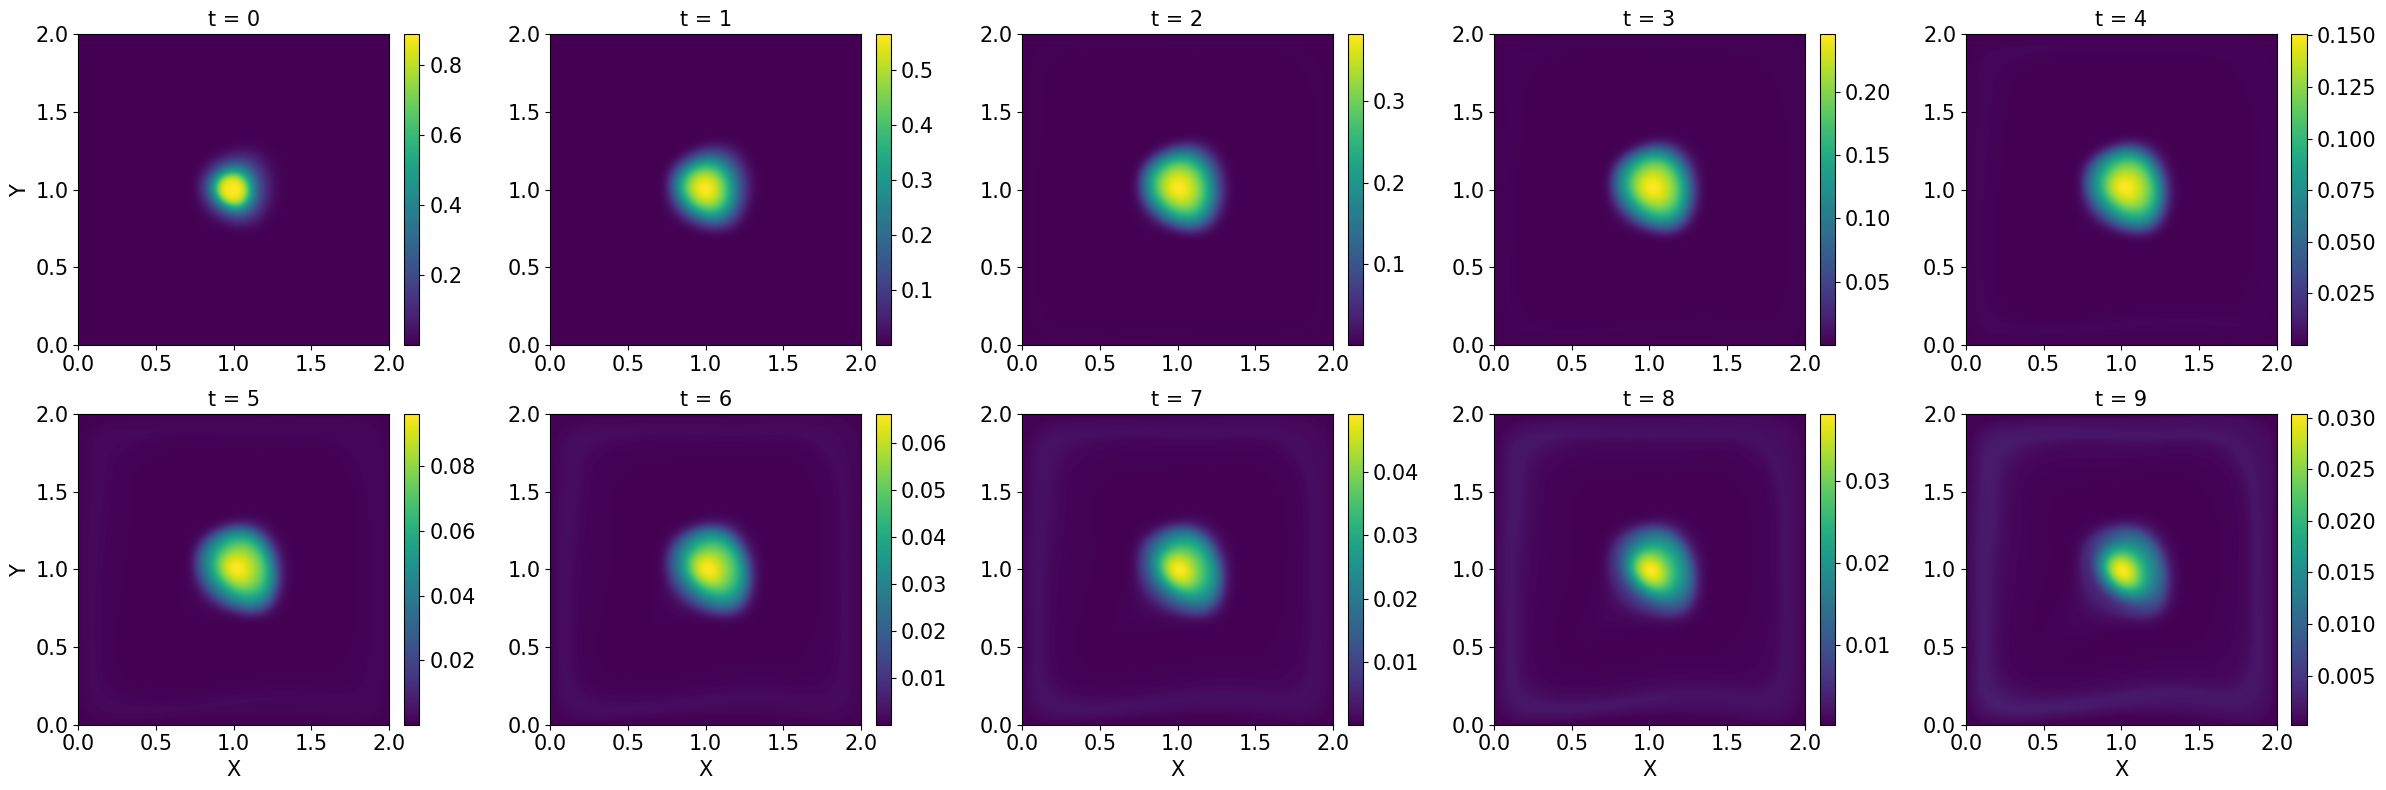

In [4]:
# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

job = 1134464

path_al_archivo = f"adaptive_pinns_DI0.0005_beta1.0_job{job}.pth"

# Cargar modelo
model = FireSpread_PINN().to(device)
checkpoint = torch.load(path_al_archivo, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Resolución espacial
Nx, Ny = 2000, 2000
x = torch.linspace(0, 1, Nx, device=device).view(-1, 1)
y = torch.linspace(0, 1, Ny, device=device).view(-1, 1)
X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x_flat, y_flat = X.flatten().view(-1, 1), Y.flatten().view(-1, 1)

# Crear grilla de subplots
fig, axes = plt.subplots(2, 5, figsize=(24, 8))  # 2 filas × 5 columnas
axes = axes.flatten()  # Para iterar fácilmente

for t_eval in range(10):
    t_fixed = torch.full_like(x_flat, t_eval, device=device)
    with torch.no_grad():
        SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
        I = SIR[:, :, 1]

    ax = axes[t_eval]
    im = ax.imshow(I, interpolation='nearest', origin='lower',
                   extent=[0, 2, 0, 2])
    ax.set_title(f"t = {t_eval}", fontsize=15)
    if t_eval == 0 or t_eval == 5:  # Solo en la primera columna
        ax.set_ylabel("Y", fontsize=15)
    if t_eval >= 5:  # Solo en la última fila
        ax.set_xlabel("X", fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=15)

# Ajustar layout
plt.tight_layout()
plt.savefig(f"solucion_pinns_{job}.pdf", dpi=600, bbox_inches='tight')
plt.show()

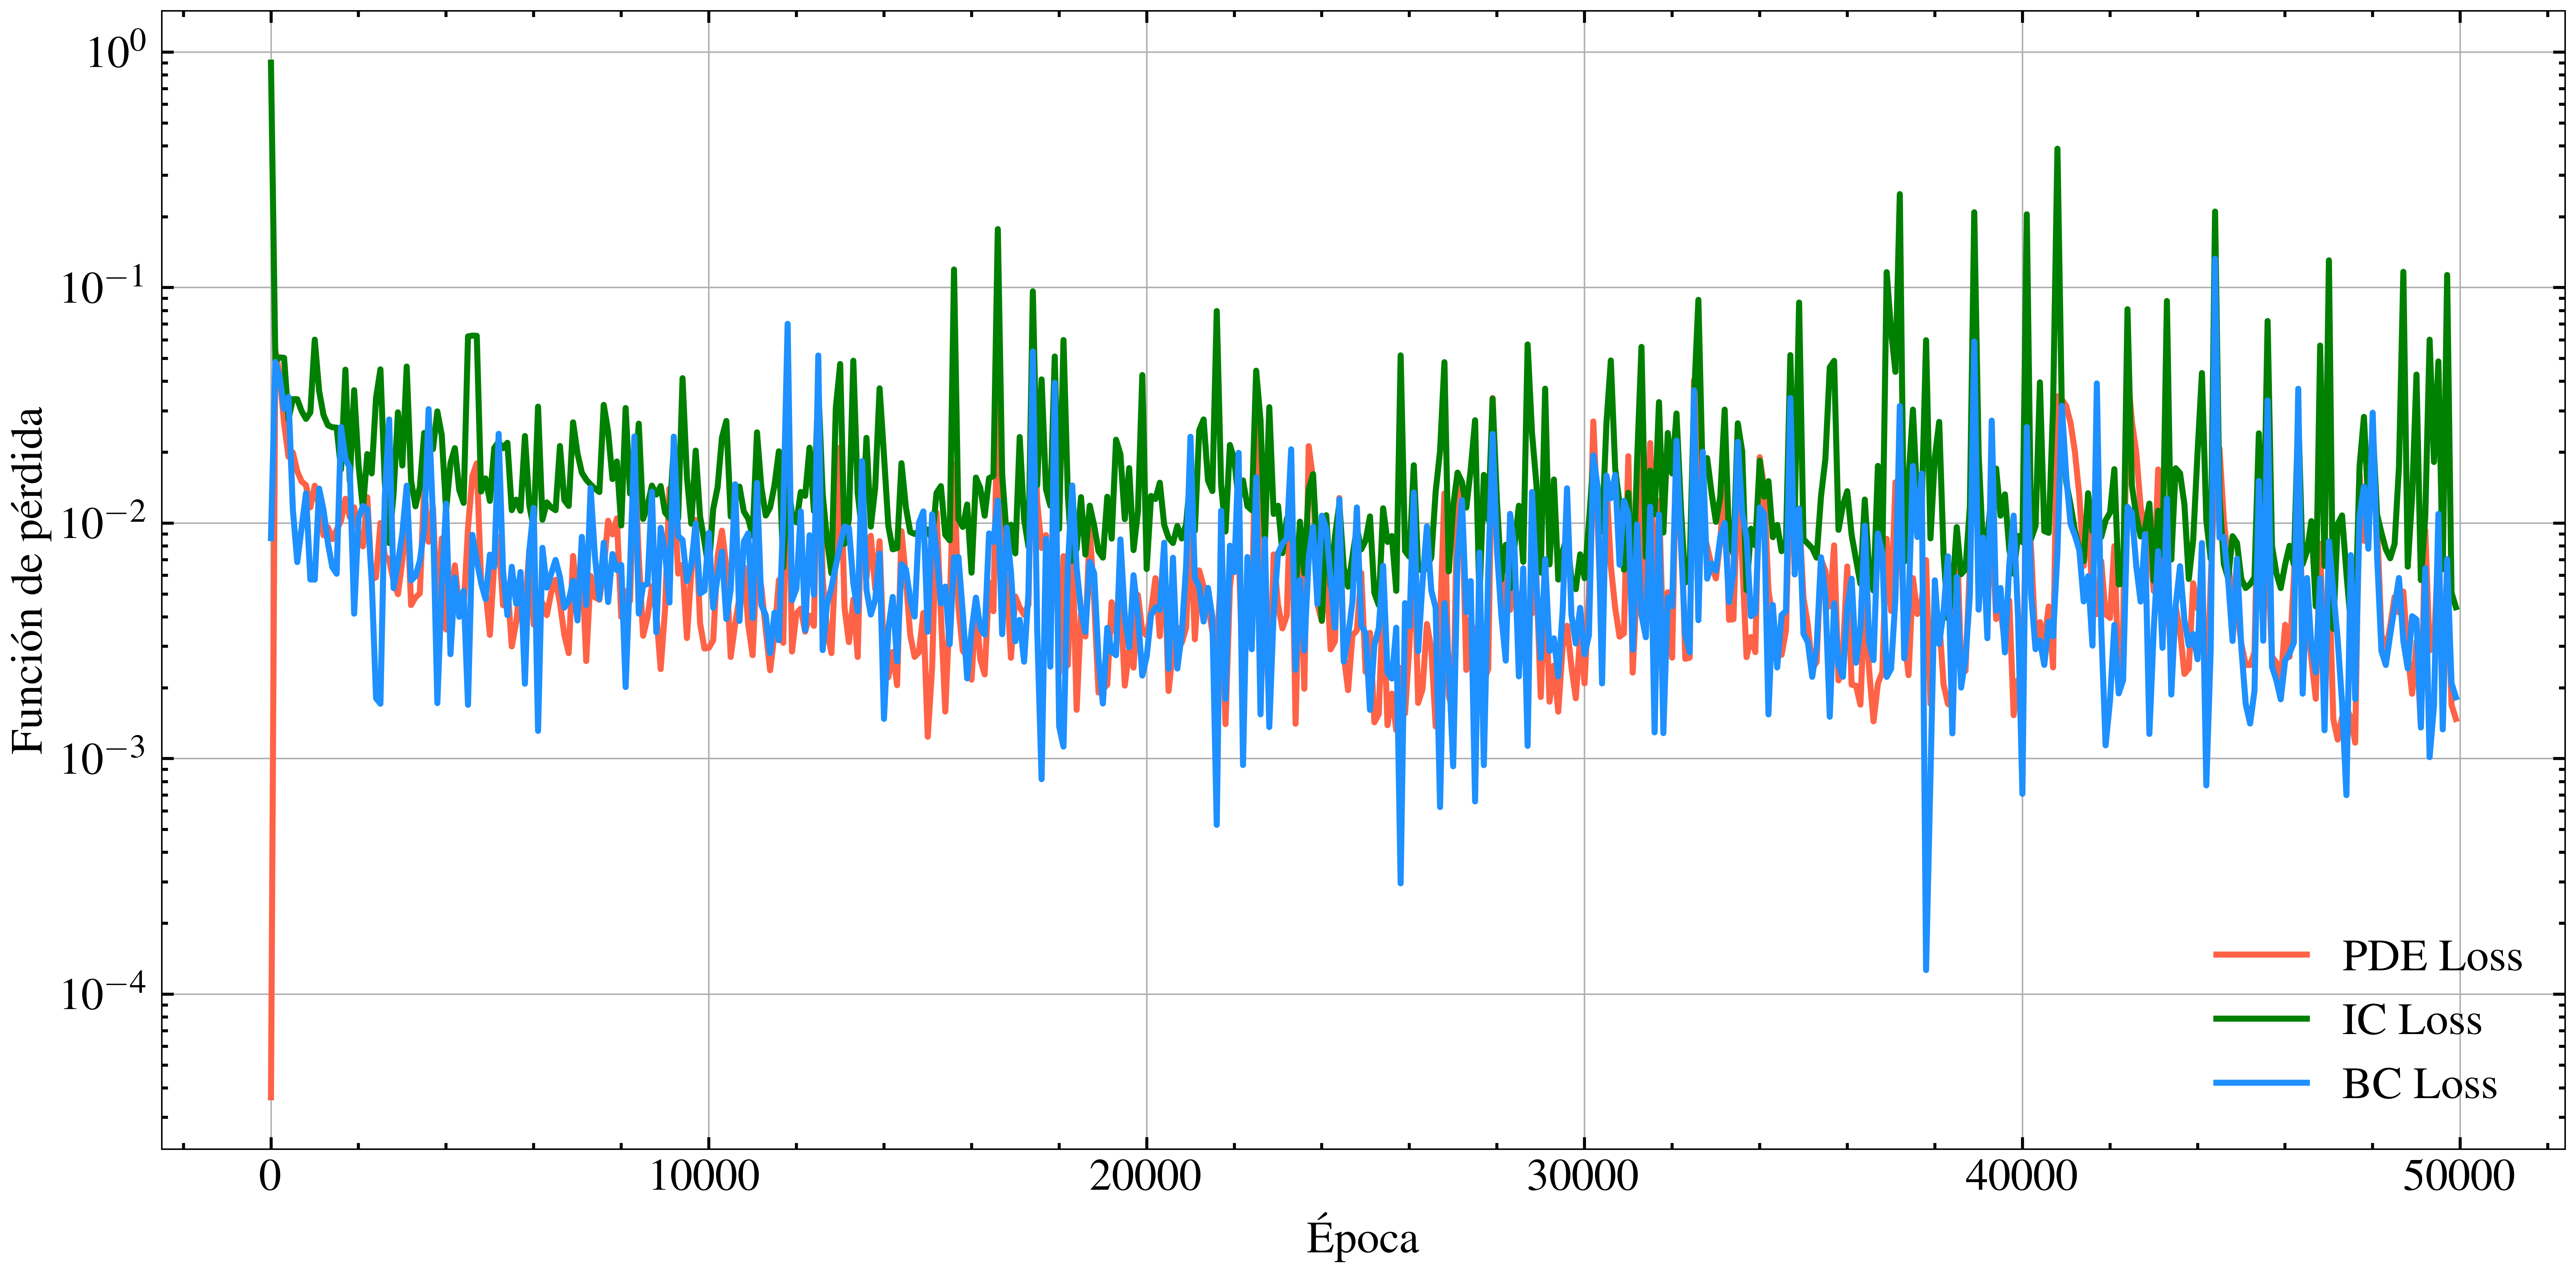

In [ ]:
import scienceplots

plt.style.use(['science', 'ieee'])

job = 1134464

loss_phys = np.load(f"loss_phys_job{job}.npy")
loss_ic = np.load(f"loss_ic_job{job}.npy")
loss_bc = np.load(f"loss_bc_job{job}.npy")

x = np.arange(len(loss_phys))

fig, ax = plt.subplots(figsize=(12,6))
ax.semilogy(x[::100], loss_phys[::100], '-', c='tomato', label='EDP', linewidth=2)
ax.semilogy(x[::100], loss_ic[::100], '-', c='green', label='CI', linewidth=2)
ax.semilogy(x[::100], loss_bc[::100], '-', c='dodgerblue', label='CB', linewidth=2)
ax.set_xlabel('Época', fontsize=15)
ax.set_ylabel('Función de pérdida', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15, length=4, width=1)
ax.tick_params(axis='both', which='minor', labelsize=15, length=2, width=1)
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"loss_pinns_{job}.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from modelo_rdc import spread_infection_adi
import cupy as cp

def ensure_batch_dim(*arrays):
    return [arr if arr.ndim == 3 else arr[cp.newaxis, ...] for arr in arrays]

In [33]:
# --- Parámetros de la Simulación ---
ny, nx = 200, 200
# Cambiado a 1001 para incluir el paso t=1000
num_steps = 1001

d = cp.float32(2 / nx)
dt = cp.float32(10 / 1000)

vegetacion = cp.full((ny, nx), 3.0, dtype=cp.float32)

beta_val = 1.0
gamma_val = 0.3

beta = cp.full_like(vegetacion, beta_val)
gamma = cp.full_like(vegetacion, gamma_val)

D_val = 5e-4
D = cp.asarray(D_val, dtype=cp.float32).reshape(1)
A = cp.asarray(0, dtype=cp.float32).reshape(1)
B = cp.asarray(0, dtype=cp.float32).reshape(1)

y = cp.linspace(0, 2, nx, dtype=cp.float32)
x = cp.linspace(0, 2, nx, dtype=cp.float32)

x_ign = 1
y_ign = 1
sigma_x = 0.05
sigma_y = 0.05

X_grilla, Y_grilla = cp.meshgrid(x, y, indexing='ij')

# Condiciones Iniciales
I = cp.exp(-0.5 * ((X_grilla - x_ign) / sigma_x)**2 - 0.5 * ((Y_grilla - y_ign) / sigma_y)**2)
S = 1 - I
R = cp.zeros_like(I)

wx = cp.zeros_like(S)
wy = cp.zeros_like(S)
h_dx = cp.zeros_like(S)
h_dy = cp.zeros_like(S)

S_new = cp.empty_like(S)
I_new = cp.empty_like(I)
R_new = cp.empty_like(R)

S, I, R, S_new, I_new, R_new, wx, wy, h_dx, h_dy, vegetacion = ensure_batch_dim(S, I, R, S_new, I_new, R_new, wx, wy, h_dx, h_dy, vegetacion)

# Diccionario para guardar el estado de I
# Los pasos de tiempo deseados son 0, 100, 200, ..., 900
pasos_guardar = list(range(0, 901, 100))
I_tiempos = {}

# --- Bucle de la Simulación ---
for t in range(num_steps):
    # Guardar el estado actual de I
    if t in pasos_guardar:
        # Convertir a numpy para graficar más tarde y manejar el array 2D
        # Aseguramos que la conversión se hace con I[0] para obtener el array 2D
        I_tiempos[t] = cp.asnumpy(I[0].copy())
        print(f"Guardando paso t = {t}...")

    spread_infection_adi(S, I, R, S_new, I_new, R_new, dt, d, beta, gamma, D,
                         wx, wy, h_dx, h_dy, A, B, vegetacion)

    # Swap de Buffers
    S, S_new = S_new, S
    I, I_new = I_new, I
    R, R_new = R_new, R

Guardando paso t = 0...
Guardando paso t = 100...
Guardando paso t = 200...
Guardando paso t = 300...
Guardando paso t = 400...
Guardando paso t = 500...
Guardando paso t = 600...
Guardando paso t = 700...
Guardando paso t = 800...
Guardando paso t = 900...


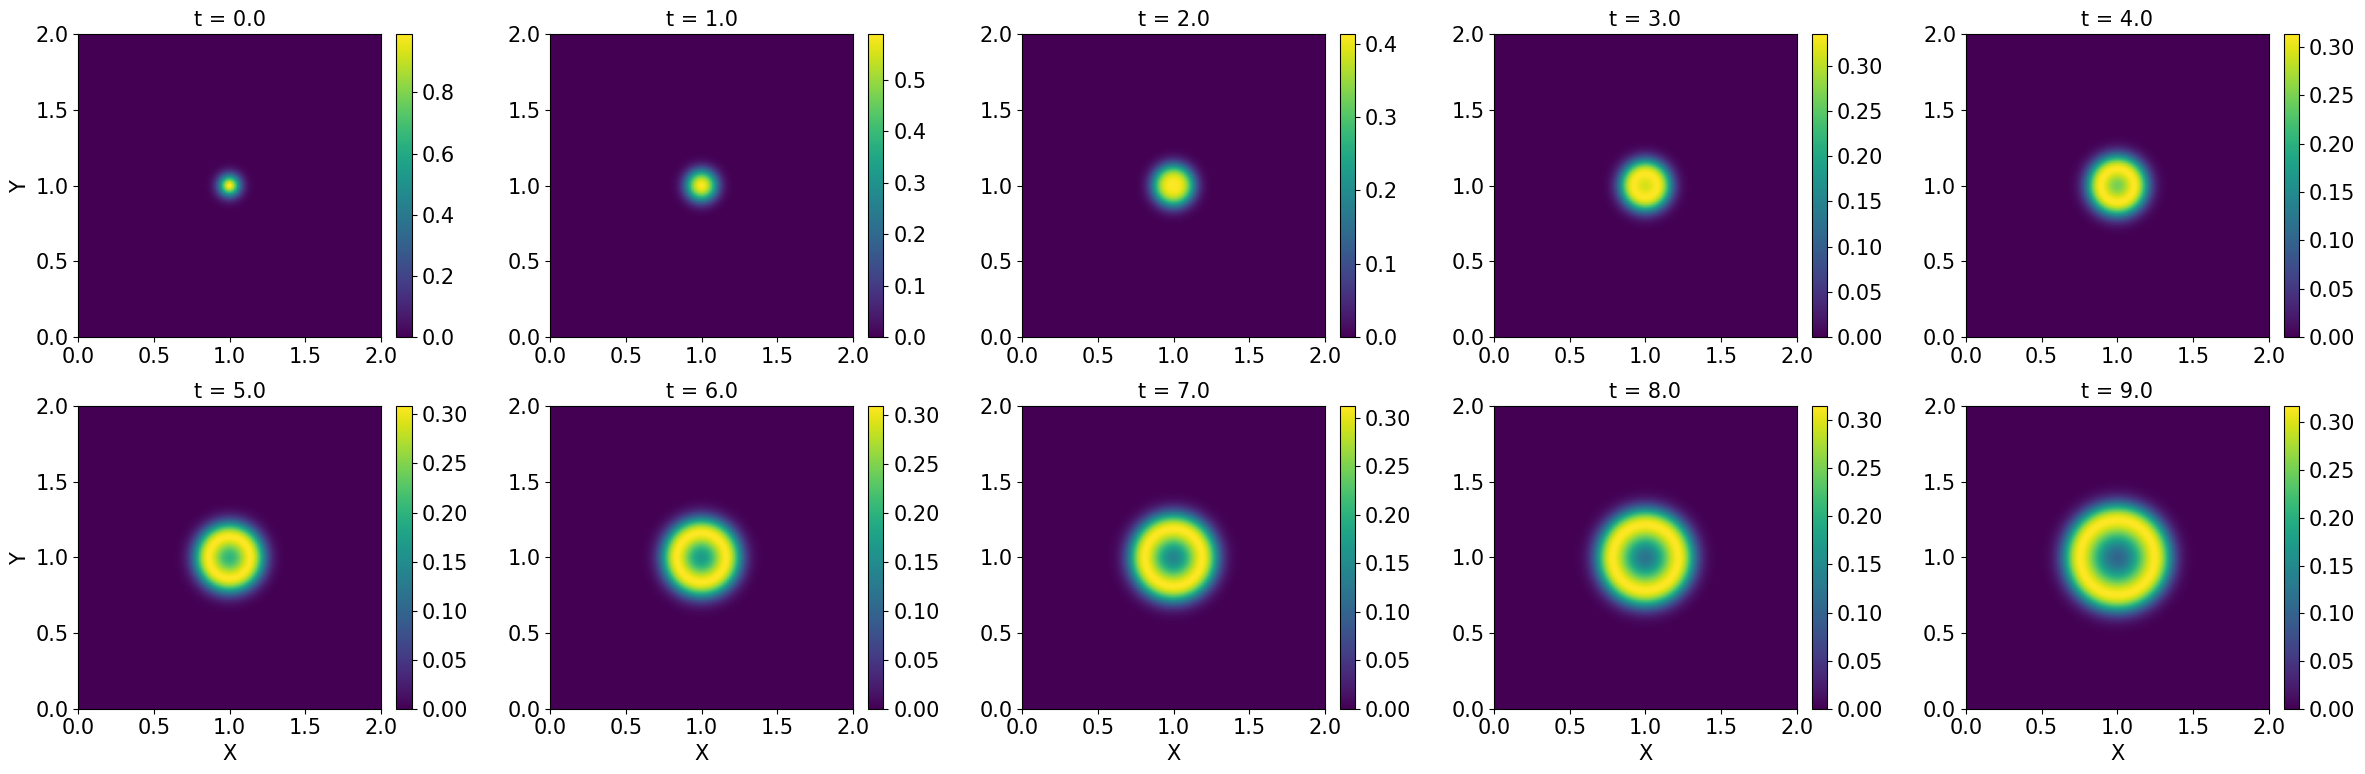

In [44]:
# --- Código de Visualización Ajustado ---

# Ordenar los tiempos para asegurar el orden correcto en el gráfico
pasos_ordenados = sorted(I_tiempos.keys())
n_plots = len(pasos_ordenados) # Esto debe ser 11

# Usamos 3 filas y 4 columnas. Tendremos 1 subplot vacío al final.
n_filas = 2
n_columnas = 5

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(24, 8))
# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Usaremos 'viridis', que es el colormap por defecto que se asemeja al ejemplo
cmap_to_use = 'viridis'

# En tu ejemplo, el valor máximo (vmax) varía, pero para tener una comparación
# visual adecuada, es mejor fijar el vmax a 1.0 (la proporción máxima de I).
# Si quieres que varíe dinámicamente como en tu imagen, puedes usar vmax=None.
# Para este ejemplo, lo fijaré a 1.0 para mejor comparación, pero dejaré un valor
# que podría variar. En el ejemplo, el rango es pequeño: [0, 0.08] en t=9.
# Vamos a fijar un vmax bajo para mejor detalle de la difusión.

for i, t in enumerate(pasos_ordenados):
    ax = axes[i]
    # Recuperamos el array 2D de la simulación
    I_data = I_tiempos[t]

    # La función imshow recibe los parámetros extent=[x_min, x_max, y_min, y_max]
    # para mapear los índices de la matriz a los valores de los ejes.
    # En tu caso, la grilla va de 0 a 2.
    im = ax.imshow(I_data, cmap=cmap_to_use, origin='lower',
                   extent=[0, 2, 0, 2])

    # Título en el formato simple 't = [tiempo]'
    ax.set_title(f't = {t*dt}', fontsize=15)

    # Etiquetas de los ejes
    if i == 0 or i == n_columnas:  # Solo en la primera columna
        ax.set_ylabel('Y', fontsize=15)

    if i >= (n_filas - 1) * n_columnas:  # Solo en la última fila
        ax.set_xlabel('X', fontsize=15)
    
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Añadir barra de color específica para cada subplot
    # Esto es lo que permite que el rango de colores cambie como en tu ejemplo.
    # Si quieres que el rango sea fijo, omite la siguiente sección y usa una barra de color común.
    # --- Si quieres rango de colores variable (como en la imagen): ---
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajustar tamaño y padding de la barra
    cbar.ax.tick_params(labelsize=15)
    # Si quisieras que el rango fuera fijo para comparación, deberías usar:
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Eliminar el subplot vacío (el último, ya que n_plots = 11 y tenemos 12 ejes)
for i in range(n_plots, n_filas * n_columnas):
    fig.delaxes(axes[i])

# Ajustar el espacio entre los subplots para que se vean bien
plt.tight_layout(rect=[0, 0, 1, 0.98]) # El rect ajusta el espacio para el título general si lo hubiera
plt.savefig("solucion_numerica_reaccion_difusion.pdf", dpi=600, bbox_inches='tight')

plt.show()

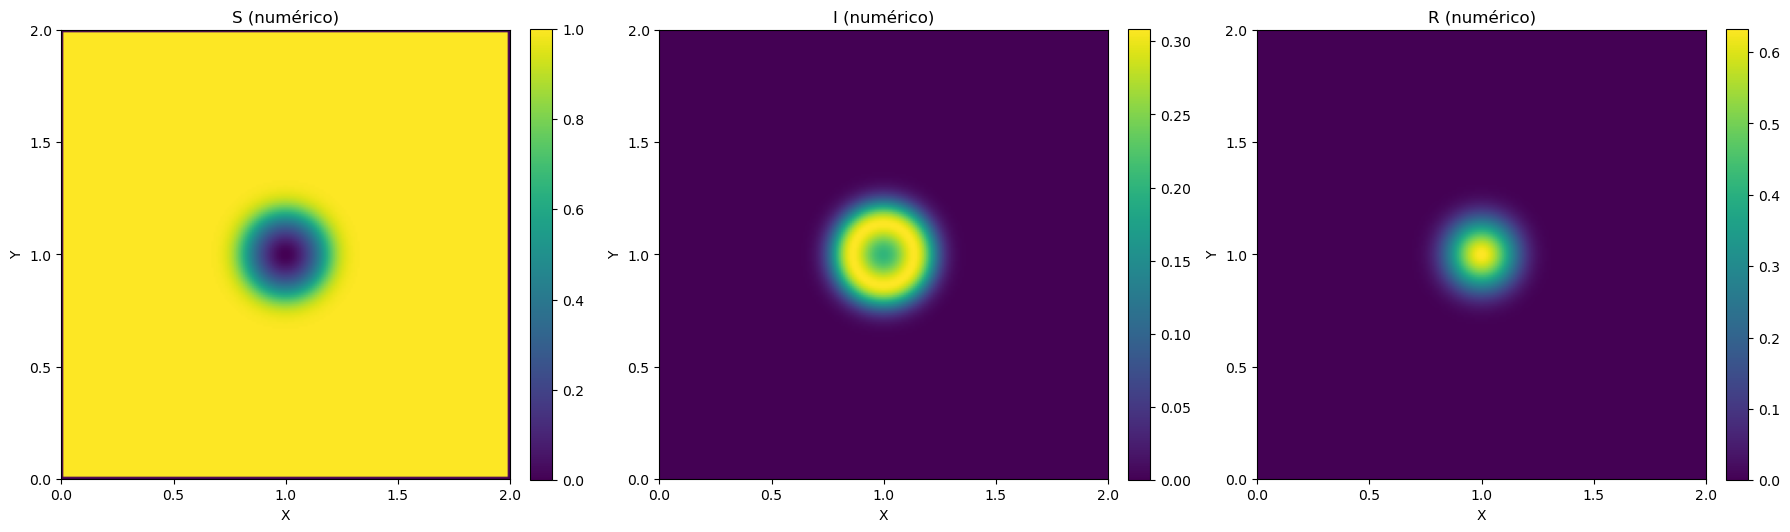

In [28]:
import matplotlib.pyplot as plt

R_numpy = cp.squeeze(R.get())
S_numpy = cp.squeeze(S.get())
I_numpy = cp.squeeze(I.get())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, data, title in zip(axes, [S_numpy, I_numpy, R_numpy], ["S (numérico)", "I (numérico)", "R (numérico)"]):
    # No fijar vmin/vmax: cada imagen tendrá su propia escala de color
    im = ax.imshow(data, origin='lower', extent=[0, 2, 0, 2],
                   aspect='equal', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xticks(np.linspace(0, 2, 5))
    ax.set_yticks(np.linspace(0, 2, 5))
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

np.save(f"S_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps*dt}.npy", S_numpy)
np.save(f"I_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps*dt}.npy", I_numpy)
np.save(f"R_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps*dt}.npy", R_numpy)


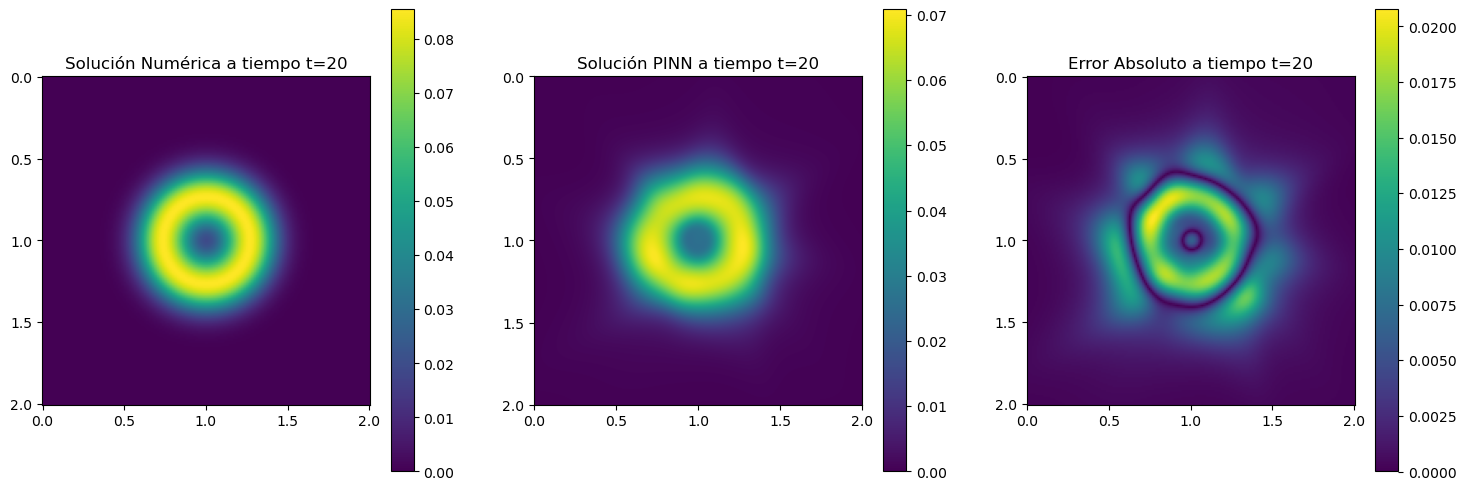

Error absoluto medio: 0.0032199547
Error absoluto máximo: 0.020758405
Error absoluto mínimo: 2.8669904e-14


In [ ]:
R_numpy = cp.squeeze(R.get())
S_numpy = cp.squeeze(S.get())
I_numpy = cp.squeeze(I.get())

t_eval = 20

t_fixed = torch.full_like(x_flat, t_eval, device=device)
with torch.no_grad():
    SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
    I_pinn = SIR[:, :, 1]

figs, axes = plt.subplots(1, 3, figsize=(18, 6))

ax1, ax2, ax3 = axes
im1 = ax1.imshow(I_numpy, aspect='equal')
cbar1 = figs.colorbar(im1, ax=ax1)
ax1.set_xticks(np.linspace(0, I_numpy.shape[1]-1, 5))
ax1.set_xticklabels(np.linspace(0, 2, 5))
ax1.set_yticks(np.linspace(0, I_numpy.shape[0]-1, 5))
ax1.set_yticklabels(np.linspace(0, 2, 5))
ax1.set_title(f"Solución Numérica a tiempo t={t_eval}")

im2 = ax2.imshow(I_pinn, aspect='equal')
cbar2 = figs.colorbar(im2, ax=ax2)
ax2.set_xticks(np.linspace(0, I_pinn.shape[1]-1, 5))
ax2.set_xticklabels(np.linspace(0, 2, 5))
ax2.set_yticks(np.linspace(0, I_pinn.shape[0]-1, 5))
ax2.set_yticklabels(np.linspace(0, 2, 5))
ax2.set_title(f"Solución PINN a tiempo t={t_eval}")

error_abs = np.abs(I_pinn[::10, ::10] - I_numpy)
im3 = ax3.imshow(error_abs, aspect='equal')
cbar3 = figs.colorbar(im3, ax=ax3)
ax3.set_xticks(np.linspace(0, error_abs.shape[1]-1, 5))
ax3.set_xticklabels(np.linspace(0, 2, 5))
ax3.set_yticks(np.linspace(0, error_abs.shape[0]-1, 5))
ax3.set_yticklabels(np.linspace(0, 2, 5))
ax3.set_title(f"Error Absoluto a tiempo t={t_eval}")

plt.show()

# Mostrar el error medio y máximo
print("Error absoluto medio:", np.mean(error_abs))
print("Error absoluto máximo:", np.max(error_abs))
print("Error absoluto mínimo:", np.min(error_abs))


Error absoluto medio: 0.0005957311
Error absoluto máximo: 0.078758895


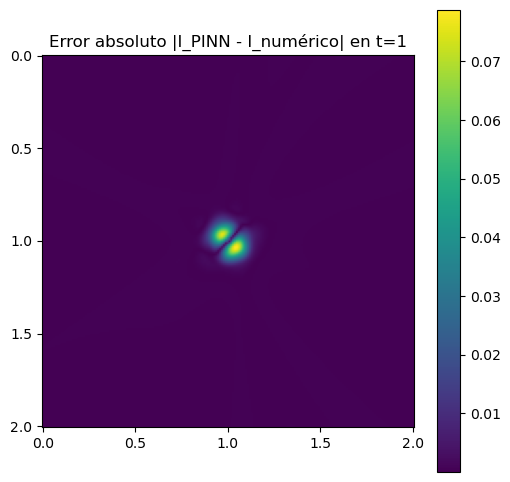

In [63]:
# Calcular el error absoluto entre la PINN y la solución numérica en t=0
x_flat, y_flat = X.flatten().view(-1, 1), Y.flatten().view(-1, 1)

t_fixed = torch.full_like(x_flat, 0, device=device)
with torch.no_grad():
    SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
    I_pinn = SIR[:, :, 1]

# Error absoluto
error_abs = np.abs(I_pinn[::10, ::10] - I_numpy)

# Mostrar el error medio y máximo
print("Error absoluto medio:", np.mean(error_abs))
print("Error absoluto máximo:", np.max(error_abs))

# Visualizar el mapa de error
plt.figure(figsize=(6, 6))
plt.imshow(error_abs, cmap='viridis', aspect='equal')
plt.title("Error absoluto |I_PINN - I_numérico| en t=1")
plt.xticks(np.linspace(0, error_abs.shape[1]-1, 5), np.linspace(0, 2, 5))
plt.yticks(np.linspace(0, error_abs.shape[0]-1, 5), np.linspace(0, 2, 5))
plt.colorbar()
plt.show()

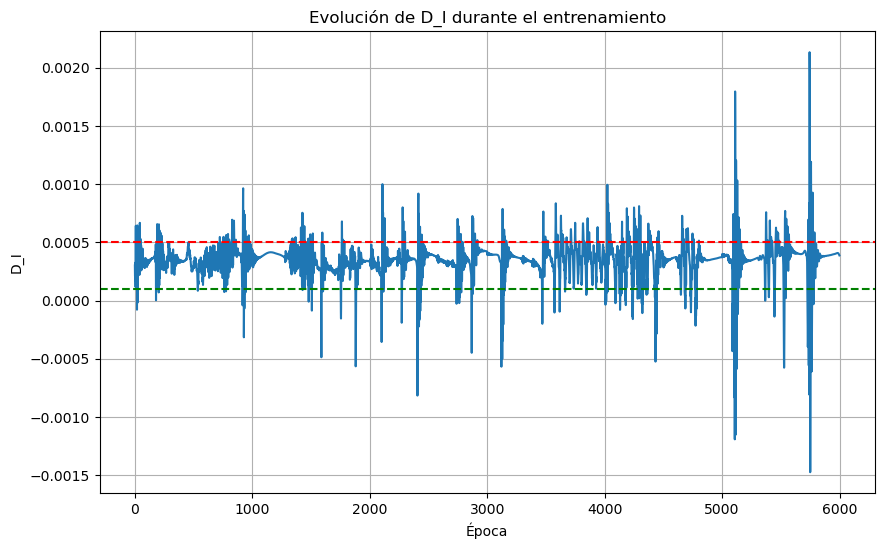

In [5]:
import numpy as np
import matplotlib.pyplot as plt

D_I_history = np.load("D_I_history.npy")

plt.figure(figsize=(10, 6))
plt.plot(D_I_history[4000:])
plt.axhline(y=5e-4, color='r', linestyle='--', label='D_I objetivo (5e-4)')
plt.axhline(y=1e-4, color='g', linestyle='--', label='D_I inicial (1e-4)')
plt.title("Evolución de D_I durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("D_I")
plt.grid()
plt.show()
